In [1]:
# THIS FUNCTION TAKES A CSV FILE FROM A GITHUB URL AND READS IT INTO A PANDAS DATA FRAME
import numpy as np
import pandas as pd

np.random.seed(11)


def read_file(url):

    """
    Takes GitHub url as an argument,
    pulls CSV file located @ github URL.

    """

    url = url + "?raw=true"
    df = pd.read_csv(url, encoding="utf-8")
    return df


# READ FILE FROM GITHUB REPO
url = "https://github.com/john-adeojo/Reddit_WallStreet/blob/main/reddit_wsb.csv"
reddit = read_file(url)

In [2]:
print(reddit.shape)
reddit.drop_duplicates(inplace=True)
print(reddit.shape)

(24057, 8)
(24057, 8)


In [3]:
reddit.shape

(24057, 8)

In [4]:
# Start by identifying the ifrst post in the data to mention GME or Gamestop explictly

# Isolate posts containing gamestop in body or title anywhere
gamestop = reddit.loc[
    (reddit.title.str.contains("gamestop", case=False) == True)
    | (reddit.title.str.contains("gme", case=False) == True)
    | (reddit.body.str.contains("gamestop", case=False) == True)
    | (reddit.body.str.contains("gme", case=False) == True)
].copy()

# Identify the first post to reference gamestop (either gme or gamestop) explicitly
first_post = gamestop.loc[gamestop.timestamp == min(gamestop.timestamp)].copy()
first_post


# Many of the top voted posts are photos or external links, let's romve those
gme_written_posts = gamestop.loc[gamestop.body.isnull() == False].copy()

In [5]:
# Convert timestamp to datetime and get date from
gme_written_posts.timestamp = pd.to_datetime(gme_written_posts.timestamp, utc=True)
gme_written_posts["date"] = pd.to_datetime(gme_written_posts.timestamp.dt.date)

In [6]:
# Clean the body of the text
import re

# Define function to remov URLS 
gme_written_posts["body_clean"] = gme_written_posts.body.apply(
    lambda x: re.sub(r"http\S+", "", x)
)

gme_written_posts["body_clean"] = gme_written_posts.body.apply(
    lambda x: re.sub(r"https\S+", "", x)
)

gme_written_posts["body_clean"] = gme_written_posts.body_clean.apply(
    lambda x: re.sub(r"\s{2,}", "", x)
)

In [7]:
# Lets Isolate some of the noise and just look at the top posts
gme_written_posts.sort_values(by="score", ascending=False, inplace=True)
# Get posts by cumulative scores
gme_written_posts["cumulative"] = gme_written_posts.score.cumsum()
# Calculate cumulative percentages
gme_written_posts["cumsum_perc"] = (
    gme_written_posts.cumulative / gme_written_posts.score.sum()
)
# take the top 90% of posts by cumulative score
top_posts = gme_written_posts.loc[gme_written_posts.cumsum_perc <= 0.95].copy()

In [8]:
import sentence_transformers
import torch
from sentence_transformers import SentenceTransformer


# Transform each clean text to 512 dimensional vectors (embeddings)
def embed(data):
    model = SentenceTransformer("distilbert-base-nli-mean-tokens")
    embeddings = model.encode(data, show_progress_bar=True)
    return embeddings

In [9]:
import umap


# Peform dimensionality reduction on the embeddings
# helps improve the eprformance of HDBSCAN
# high dimensionality is often handled poorly
def umap_embed(embeddings, n_neighbors):
    np.random.seed(42)
    umap_embeddings = umap.UMAP(
        n_neighbors=n_neighbors, n_components=10, metric="cosine"
    ).fit_transform(embeddings)
    return umap_embeddings

In [10]:
# umap_embeddings.shape

In [11]:
# Perform HDBSCAN clustering
import hdbscan


def clusters(umap_embeddings, n_neighbors):
    np.random.seed(42)
    cluster = hdbscan.HDBSCAN(
        min_cluster_size=n_neighbors, metric="euclidean", cluster_selection_method="eom"
    ).fit(umap_embeddings)
    return cluster

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


# Prepare data: Reduce dimensionality to 2 dimensions so we can visulaise the clusters
def visualise_2d(embeddings, n_neighbors, name):
    np.random.seed(42)
    umap_data = umap.UMAP(
        n_neighbors=n_neighbors, n_components=2, min_dist=0.0, metric="cosine"
    ).fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=["x", "y"])
    result["labels"] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    ax.set_title(name)
    plt.scatter(outliers.x, outliers.y, color="#BDBDBD", s=50)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=50, cmap="hsv_r")
    plt.colorbar()
    plt.savefig(name)

In [13]:
# Lets attach labels to these clusters to get our topics


def docs_per_topics(data):
    # Read text body list into dataframe
    docs_df = pd.DataFrame(data, columns=["Doc"])
    # bring in cluster labels
    docs_df["Topic"] = cluster.labels_
    # Aggregate text body by cluster
    docs_df["Doc_ID"] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(["Topic"], as_index=False).agg({"Doc": " ".join})

    return docs_per_topic, docs_df


# Apply class based TF-IDF
# The frequency % of each word is caulcated at the class level

from sklearn.feature_extraction.text import CountVectorizer


def c_tf_idf(documents, m, ngram_range=(1, 1)):
    
    # Count words but Remove stop words to get a more meaningful insight
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(
        documents
    )
    
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.around(np.multiply(tf, idf),5)

    return tf_idf, count


def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {
        label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1]
        for i, label in enumerate(labels)
    }
    return top_n_words


def extract_topic_sizes(df):
    topic_sizes = (
        df.groupby(["Topic"])
        .Doc.count()
        .reset_index()
        .rename({"Topic": "Topic", "Doc": "Size"}, axis="columns")
        .sort_values("Size", ascending=False)
    )
    return topic_sizes

In [14]:
def mergetopics(docs_per_topic, topic_sizes):

    # Bring it all together to get a summary of topics, all text bodies within the topic and top size.
    docs_per_topic["Topic_words"] = docs_per_topic.Topic.map(top_n_words)
    reddit_topics = pd.merge(docs_per_topic, topic_sizes, how="left", on="Topic")

    return reddit_topics

In [15]:
import transformers
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Define funtion for summariser pegasus-reddit_tifu (pretrained model)


def summarise_topics(reddit_topics):

    # Initialise model and tokenizer
    model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-reddit_tifu")
    tokenizer = AutoTokenizer.from_pretrained("google/pegasus-reddit_tifu")

    # Run tokenizer
    reddit_topics["inputs"] = reddit_topics.Doc.apply(
        lambda x: tokenizer.encode(
            x, padding=True, truncation=True, return_tensors="pt"
        )
    )

    # Generate Summary
    reddit_topics["summary_code"] = reddit_topics.inputs.apply(
        lambda x: model.generate(x, num_beams=4, max_length=500, early_stopping=True)
    )
    reddit_topics["summarised"] = reddit_topics.summary_code.apply(
        lambda x: [
            tokenizer.decode(
                g, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )
            for g in x
        ]
    )
    return reddit_topics

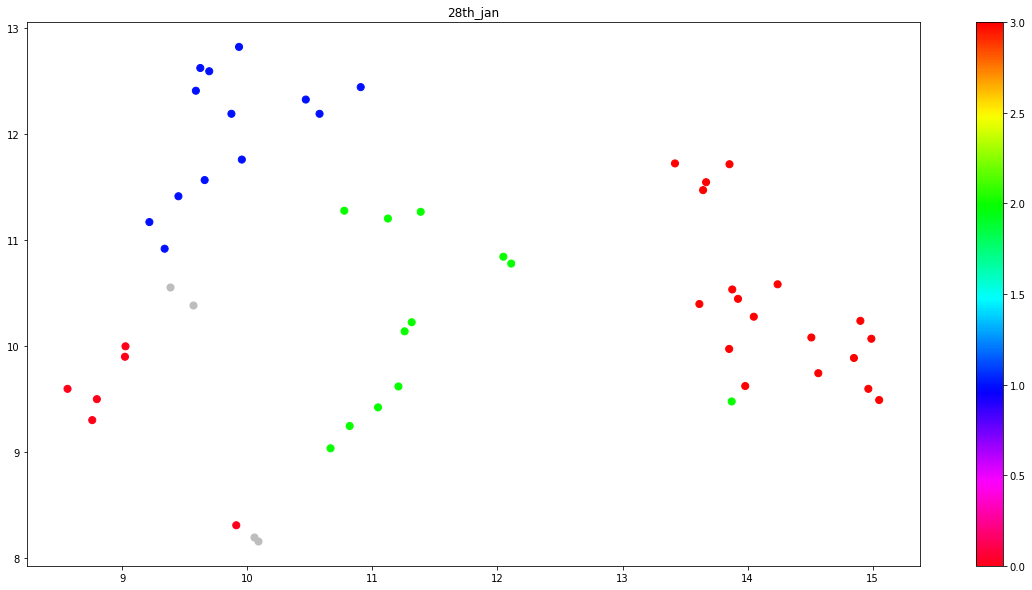

In [16]:
# CLUSTER AND SUMMARISE TEXT RUNWAY: WHERE DATE IS 28TH JAN

posts_28th = top_posts.loc[top_posts.date == "2021-01-28"].copy()
data = list(posts_28th.body_clean)

# Step 1: vectorise text-body to get embeddings
embeddings = embed(data)
# Step 2: reduce dimensionality of the embeddings
n_neighbors = 3
umap_embeddings = umap_embed(embeddings, n_neighbors)
# Step 3: perform clustering with hdbscan
cluster = clusters(umap_embeddings, n_neighbors)
# Step 4: visualise clusters in two-dimensions
visualise_2d(embeddings, n_neighbors, "28th_jan")
# Step 5: create documents at topic level
docs_per_topic, docs_df = docs_per_topics(data)
# Step 6: Generated topics in words
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
topic_sizes = extract_topic_sizes(docs_df)
# Step 7: Return reddit topics
reddit_topics = mergetopics(docs_per_topic, topic_sizes)
# Step 8: Run PEGASUS to summarise text
# Initialise BART model and tokenizer
reddit_topics_1 = summarise_topics(reddit_topics)

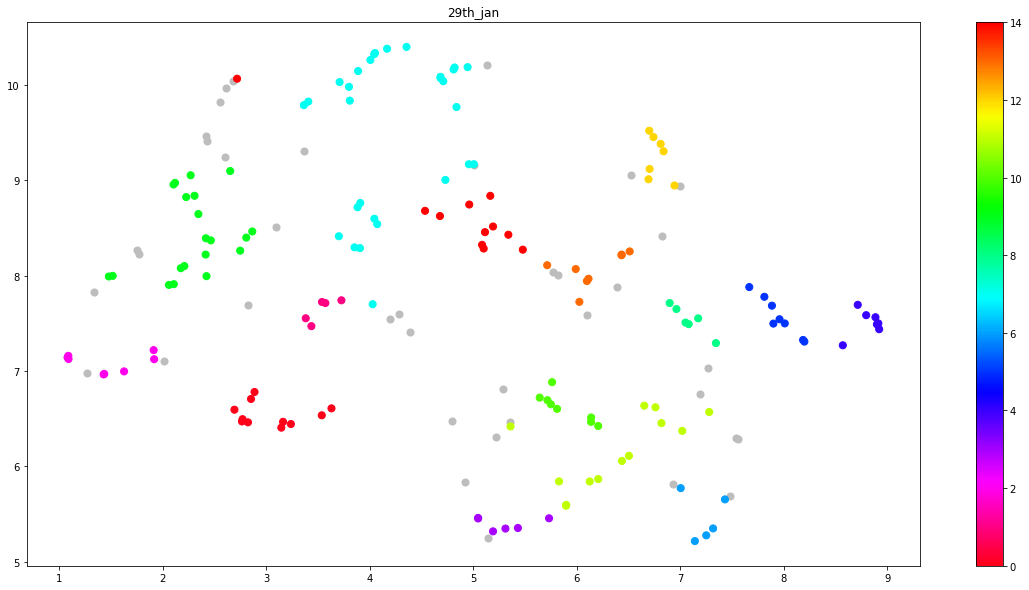

In [17]:
# 2nd ITERATION: 29th

posts_29th = top_posts.loc[top_posts.date == "2021-01-29"].copy()
data = list(posts_29th.body_clean)

# Step 1: Vectorise text-body to get embeddings
embeddings = embed(data)
# Step 2: Reduce dimensionality of the embeddings
n_neighbors = 4
umap_embeddings = umap_embed(embeddings, n_neighbors)
# Step 3: Perform clustering with hdbscan
cluster = clusters(umap_embeddings, n_neighbors)
# Step 4: Visualise clusters in two-dimensions
visualise_2d(embeddings, n_neighbors, "29th_jan")
# Step 5: Create documents at topic level
docs_per_topic, docs_df = docs_per_topics(data)
# Step 6: Generated topics in words
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
topic_sizes = extract_topic_sizes(docs_df)
# Step 7: Return reddit topics
reddit_topics = mergetopics(docs_per_topic, topic_sizes)
# Step 8: Run PEGASUS to summarise text
# Initialise BART model and tokenizer
reddit_topics_2 = summarise_topics(reddit_topics)

In [18]:
reddit_topics_1

,Topic,Doc,Topic_words,Size,inputs,summary_code,summarised
0,-1,Thank u/dmtran1987 when GME prints for you nex...,"[(million, 0.0253), (minute, 0.02024), (trader...",4,"[[tensor(1860), tensor(4911), tensor(191), ten...","[[tensor(0), tensor(380), tensor(123), tensor(...",[today’s trading volume on GME was only 94 mil...
1,0,"This is simple retards, he already publicly hi...","[(citadel, 0.01651), (happens, 0.01201), (huge...",6,"[[tensor(182), tensor(117), tensor(586), tenso...","[[tensor(0), tensor(631), tensor(165), tensor(...",[buy out the contract of the wax-headed Seinfe...
2,1,"**Mods do not delete, this is important to me...","[(slv, 0.00667), (ounces, 0.00615), (gold, 0.0...",13,"[[tensor(12937), tensor(28971), tensor(116), t...","[[tensor(0), tensor(532), tensor(2020), tensor...",[i bought shares in a firm that made money off...
3,2,Imagine co-writing the [New York Times]( bigge...,"[(td, 0.00664), (transactions, 0.00664), (arti...",12,"[[tensor(9031), tensor(1229), tensor(121), ten...","[[tensor(0), tensor(272), tensor(131), tensor(...",[don't fuck with the stock market. it's not ab...
4,3,This probably won’t get anywhere and I don’t c...,"[(censorship, 0.0049), (thesis, 0.0049), (bubb...",18,"[[tensor(182), tensor(864), tensor(576), tenso...","[[tensor(0), tensor(272), tensor(123), tensor(...","[don’t fuck with the internet, it’s not worth ..."


In [19]:
reddit_topics_2

,Topic,Doc,Topic_words,Size,inputs,summary_code,summarised
0,-1,That is not hyperbole. Money isn't just paper ...,"[(started, 0.00781), (hfts, 0.00551), (rh, 0.0...",38,"[[tensor(485), tensor(117), tensor(146), tenso...","[[tensor(0), tensor(51588), tensor(117), tenso...",[reddit is going to be filled with propaganda ...
1,0,With the announcement by Senator Feinstein tha...,"[(questions, 0.01972), (limit, 0.01755), (amer...",11,"[[tensor(441), tensor(109), tensor(5176), tens...","[[tensor(0), tensor(110), tensor(1100), tensor...",[] - - - - - - - - - - - - -]
2,1,IMPORTANT:-Revolut-Vanguard-FidelityNEVER halt...,"[(republic, 0.04417), (halted, 0.02762), (part...",5,"[[tensor(49027), tensor(151), tensor(121), ten...","[[tensor(0), tensor(12937), tensor(151), tenso...",[**:- Trade Republic halted trading for a few ...
3,2,"Yo, health check time:- Get proper sleep\n- Ea...","[(friday, 0.04252), (guaranteed, 0.03022), (do...",8,"[[tensor(11298), tensor(108), tensor(426), ten...","[[tensor(0), tensor(110), tensor(105), tensor(...",[ ]
4,3,I've been following /r/wallstreetbets for year...,"[(escalade, 0.02442), (schwab, 0.01865), (john...",6,"[[tensor(125), tensor(131), tensor(261), tenso...","[[tensor(0), tensor(532), tensor(131), tensor(...",[i'm an idiot who didn't buy in to the $GME sh...
5,4,There are 46.89 million floating shares of GME...,"[(crack, 0.05263), (rocks, 0.04112), (rock, 0....",7,"[[tensor(353), tensor(127), tensor(7052), tens...","[[tensor(0), tensor(613), tensor(316), tensor(...","[shorted GameStop, shorted a bunch of crack ro..."
6,5,[IN THIS POST I DESCRIBED HOW TO FIND THIS INF...,"[(rate, 0.02237), (borrowing, 0.02046), (gamin...",8,"[[tensor(1126), tensor(8835), tensor(7343), te...","[[tensor(0), tensor(110), tensor(1100), tensor...",[](http://i.imgur.com/a/f0xtxt.jpg) ) ) ) ) )]
7,6,This has shown up in a few comments and posts ...,"[(moderator, 0.02711), (blatant, 0.02544), (mi...",5,"[[tensor(182), tensor(148), tensor(1673), tens...","[[tensor(0), tensor(110), tensor(105), tensor(...",[ ]
8,7,"Vlad, CEO of RH and chief mod at r/cuckold, we...","[(clearing, 0.00824), (com, 0.00681), (markets...",29,"[[tensor(49320), tensor(108), tensor(2792), te...","[[tensor(0), tensor(6114), tensor(191), tensor...",[r/cuckold is a dirty pool of fucking assholes...
9,8,Please read!!! This text will be the most impo...,"[(cash, 0.02298), (days, 0.01866), (wallstreet...",6,"[[tensor(903), tensor(516), tensor(2109), tens...","[[tensor(0), tensor(110), tensor(105), tensor(...",[ ]
